In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import astropy
from astropy.table import Table
from astropy.io import fits
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
import dipole

### Steps 1-2 $\rightarrow$ `catwise_agns_corr.fits`


### Step 3 $\rightarrow$ `catwise_agns_masked_final.fits`

1. mask in TOPCAT
2. galactic plane cut
3. small cut in `w1cov`

#### mask in TOPCAT $\rightarrow$ `catwise_agns_corr_masked.fits`
Masked catalog with corrected mags and proper motions (output from Step 2 + Sky Ellipses "All Match" Join Type 1 not 2 where 1 is the catalog `catwise_agns_corr.fits` and 2 is the mask file `MASKS_exclude_master_final.fits`)

In [3]:
cattab = Table.read(f'/scratch/aew492/quasars/catalogs/catwise_agns/catwise_agns_corr_masked.fits', format='fits')

In [4]:
cattab

source_id,ra,dec,sigra,sigdec,sigradec,w1cov,w2cov,meanobsmjd,pmra,pmdec,sigpmra,sigpmdec,ebv,w1,w2,w1e,w2e,w12,w12e,tile,l,b,elon,elat,radius,radius2,pa
,deg,deg,arcsec,arcsec,arcsec,,,d,arcsec / yr,arcsec / yr,arcsec / yr,arcsec / yr,mag,mag,mag,mag,mag,mag,mag,,deg,deg,deg,deg,,,
bytes27,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,bytes8,float64,float64,float64,float64,int64,int64,int64
0000m016_b0-005603,359.41333750412764,-2.167267788407,0.0704,0.0699,-0.026,145.7,145.6,57172.630752,-0.01304579,0.0005776460000000011,0.03198,0.030444,0.040162895,16.136144306216387,14.989762870578096,0.02900000000094301,0.030000000000180063,1.1463814356382915,0.041725292090835,0000m016,93.36046431987428,-61.91100125480427,358.5994638365189,-1.755045763918577,0,0,0
0000m016_b0-010596,0.5450644041276,-1.177598988407,0.0934,0.0936,-0.0345,146.2,138.0,57206.949034,-0.08155579,-0.06885235399999999,0.044895,0.042362,0.04405317,16.410673971552402,15.369449314290657,0.03600000000075965,0.043000000000125625,1.0412246572617452,0.056080299571823776,0000m016,96.40152494864323,-61.485784856383,0.0315948577830099,-1.2972316580992056,0,0,0
0000m016_b0-005401,359.3693827041276,-1.7931065884069999,0.0737,0.0687,-0.025,145.3,144.1,57220.242888,0.052324209999999996,-0.029592353999999998,0.031734,0.029854,0.044649728,15.949601848069578,15.127401231968776,0.027000000001012863,0.03400000000015888,0.8222006161008029,0.04341658669293912,0000m016,93.62288294310186,-61.555357561551205,358.7080846825455,-1.3943010138585823,0,0,0
0000m016_b0-008110,0.0617950041276,-1.175226988407,0.0818,0.0811,-0.0253,149.2,145.3,57181.513037,-0.01082579,0.014407646,0.038376,0.03717,0.038658805,16.42132615067437,15.139884100371972,0.03400000000080434,0.03200000000016881,1.2814420503023989,0.046690470120416425,0000m016,95.48058894820512,-61.28840869196749,359.58916065153176,-1.102823551893205,0,0,0
0000m016_b0-007151,359.82987120412764,-1.977838988407,0.0773,0.0773,-0.0286,149.3,146.8,57218.25157,0.05061421000000001,-0.010832353999999999,0.036654,0.034928,0.040941555,16.2090501662679,15.208700110612437,0.03100000000088217,0.03600000000015005,1.0003500556554634,0.04750789408156815,0000m016,94.331730904729,-61.920453287741665,359.05694149169165,-1.7469151408832042,0,0,0
0000m016_b0-007695,359.7304187041276,-1.2496416884069999,0.0848,0.0855,-0.0315,148.4,147.6,57216.284868,0.04191421,-0.035692353999999996,0.041082,0.03953,0.043811794,16.400703154079615,15.19946876938641,0.037000000000739115,0.035000000000154345,1.2012343846932048,0.050931326313630385,0000m016,94.78964438756488,-61.21857504577585,359.255542876,-1.039288519489612,0,0,0
0000m016_b0-006651,359.65309700412763,-0.8613792884070001,0.0802,0.0748,-0.0296,150.7,148.3,57223.091816,-0.03488579,-0.010532354,0.036531,0.03245,0.04046587,16.161107676368207,15.321738450834527,0.02900000000094301,0.038000000000142156,0.8393692255336802,0.04780167361155359,0000m016,94.9801693285279,-60.8335987592685,359.339081045451,-0.6523166777257233,0,0,0
0000m016_b0-001610,359.3862815041276,-1.414645588407,0.0322,0.0296,-0.0109,156.7,154.8,57237.61135,0.023094209999999997,-0.004912354000000001,0.011069999999999998,0.010384000000000001,0.03438262,14.723843141339719,13.526228760970756,0.01600000000170921,0.013000000000415533,1.1976143803689627,0.020615528129676874,0000m016,93.9971234549282,-61.221587834110984,358.8741893650386,-1.0538014107795688,0,0,0


In [5]:
# make a working copy with proper W1 cut
cattab_ = cattab[cattab['w1']<=16.4]

In [6]:
len(cattab_)

2699096

$\Rightarrow$ Yes this matches the number of sources listed in the README !

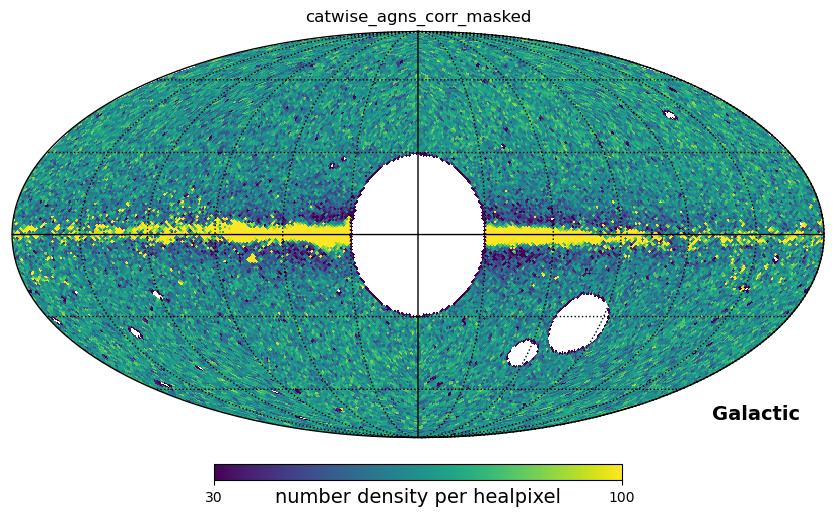

In [7]:
fullskymap = tools.load_catalog_as_map(cattab_, frame='galactic')
fullskymap[fullskymap==0.] = hp.UNSEEN
tools.mollview(fullskymap, coord='G', title='catwise_agns_corr_masked', badcolor='white', norm='log', min=30, max=100)

#### Galactic plane cut, keep $|b|>30^\circ$

In [8]:
cattab_ = cattab_[np.abs(cattab_['b']) > 30]

In [9]:
len(cattab_) # correct source count

1355409

#### Cut `w1cov < 80`

"There is a small population of objects (57) with `w1cov < 80`. These have spuriously high  `w12` color. Remove these."

In [10]:
sum(cattab_['w1cov'] < 80)

57

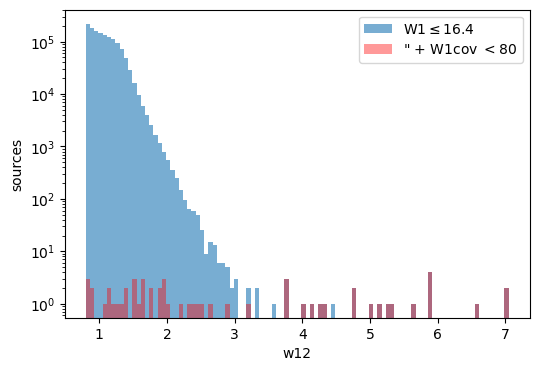

In [11]:
fig, ax = plt.subplots(figsize=(6,4))
_, bins, _ = ax.hist(cattab_['w12'], bins=100, alpha=0.6, label='W1$\leq 16.4$')
_, _, _ = ax.hist(cattab_['w12'][cattab_['w1cov'] < 80], bins=bins, color='r', alpha=0.4,
                  label='" + W1cov $<80$')
ax.set_yscale('log')
ax.set_xlabel('w12')
ax.set_ylabel('sources')
ax.legend()

In [12]:
cattab_ = cattab_[cattab_['w1cov'] >= 80]

In [13]:
len(cattab_)  # correct source count : **this is the number of sources in the final catalog**

1355352

In [14]:
# check out final catalog as healpix map
catmap = tools.load_catalog_as_map(cattab_, frame='galactic', dtype=np.float64)

In [15]:
catmap[catmap==0.] = hp.UNSEEN

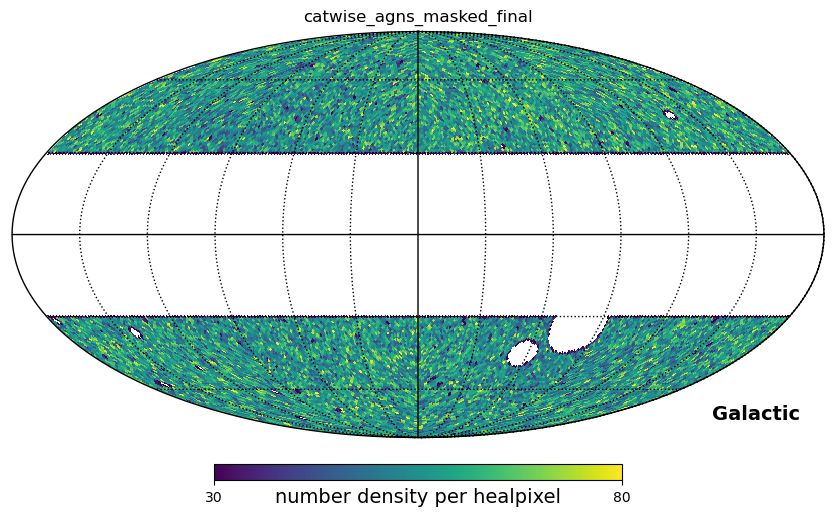

In [16]:
tools.mollview(catmap, coord='G', min=30, max=80, title='catwise_agns_masked_final', badcolor='white')

In [17]:
# cattab_.write('/scratch/aew492/quasars/catalogs/catwise2020/catwise_agns_masked_final.fits', format='fits')

**measure dipole** in this map

In [18]:
amps, err = dipole.fit_dipole(catmap, idx=(catmap!=hp.UNSEEN))

In [19]:
dipole.get_dipole(amps, frame='galactic')

(0.014653933869290302,
 <SkyCoord (Galactic): (l, b) in deg
     (235.67260024, 42.9281928)>)

### Step 3 1/2 (step 6 in README): get alphas

The `README` says to get the spectral indices last, but the script `mk_hpx.py` is compatible with an input catalog that contains alpha values, and getting these values in this order doesn't otherwise affect the results.

In [20]:
# check out lookup table
a = Table.read('/home/aew492/lss-dipoles/Secrest/alpha_colors.fits')

In [21]:
a

alpha,k_G,k_W1,nu_G_iso,nu_W1_iso,BP_G,BP_RP,G_RP,G_W1,W1_W2
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-12.0,5.837289768255837e+155,6.50166380116664e+147,398581928740572.9,86646703076466.89,3.8876128924414814,5.34689816432477,1.4592852718832887,22.450966860223723,4.702741189847728
-11.999,5.645123113854358e+155,6.296484102150781e+147,398586723198433.1,86646891874742.06,3.8872256955367774,5.346488659266306,1.459262963729529,22.449438266716882,4.702403737370943
-11.998,5.459282616629064e+155,6.09777945031699e+147,398591518085255.75,86647080681399.0,3.8868385053333085,5.3460791574791315,1.459240652145823,22.447909662757056,4.702066285204495
-11.997,5.279560020775956e+155,5.905345507186106e+147,398596313401066.25,86647269496436.55,3.8864513218316574,5.345669658962947,1.45921833713129,22.44638104834287,4.701728833348341
-11.996,5.105753926152969e+155,5.718984382738537e+147,398601109145946.75,86647458319862.73,3.886064145032428,5.345260163717448,1.4591960186850201,22.444852423472966,4.7013913818024236
-11.995,4.937669562598971e+155,5.538504431917163e+147,398605905319948.0,86647647151669.0,3.88567697493621,5.344850671742321,1.4591736968061113,22.443323788145932,4.701053930566701
-11.994,4.7751185716817175e+155,5.363720057551914e+147,398610701923121.06,86647835991859.11,3.8852898115436005,5.344441183037276,1.4591513714936752,22.441795142360384,4.7007164796411445
-11.993,4.617918795627779e+155,5.1944515195007786e+147,398615498955536.6,86648024840437.42,3.884902654855189,5.344031697602006,1.4591290427468167,22.440266486114957,4.700379029025697
-11.992,4.465894073203566e+155,5.0305247498170084e+147,398620296417231.5,86648213697400.27,3.8845155048715583,5.3436222154361985,1.4591067105646403,22.43873781940826,4.700041578720317


#### `lookup_alpha_catwise.py` to get spectral indices $\alpha$ $\rightarrow$ `catwise_agns_masked_final_alpha.fits`

This output catalog is the same as `catwise_agns_masked_final.fits` but with new columns `k`, `alpha_W1`, and `nu_W1_iso`.

In [22]:
alphatab = Table.read('/scratch/aew492/quasars/catalogs/catwise2020/catwise_agns_masked_final_alpha.fits', format='fits')

In [23]:
# check magnitude ranges
min(alphatab['w1']), max(alphatab['w1']), min(alphatab['w1']-alphatab['w2'])

(9.065128618855029, 16.39999942280352, 0.8000002727136017)

In [24]:
alphatab

source_id,ra,dec,sigra,sigdec,sigradec,w1cov,w2cov,meanobsmjd,pmra,pmdec,sigpmra,sigpmdec,ebv,w1,w2,w1e,w2e,w12,w12e,tile,l,b,elon,elat,radius,radius2,pa,k,alpha_W1,nu_W1_iso
,deg,deg,arcsec,arcsec,arcsec,,,d,arcsec / yr,arcsec / yr,arcsec / yr,arcsec / yr,mag,mag,mag,mag,mag,mag,mag,,deg,deg,deg,deg,,,,erg / cm2,,Hz
bytes27,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,bytes8,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64
0000m016_b0-005603,359.41333750412764,-2.167267788407,0.0704,0.0699,-0.026,145.7,145.6,57172.630752,-0.01304579,0.0005776460000000011,0.03198,0.030444,0.040162895,16.136144306216387,14.989762870578096,0.02900000000094301,0.030000000000180063,1.1463814356382915,0.041725292090835,0000m016,93.36046431987428,-61.91100125480427,358.5994638365189,-1.755045763918577,0,0,0,4.234188435875256e-07,-1.476,89156786484782.67
0000m016_b0-005401,359.3693827041276,-1.7931065884069999,0.0737,0.0687,-0.025,145.3,144.1,57220.242888,0.052324209999999996,-0.029592353999999998,0.031734,0.029854,0.044649728,15.949601848069578,15.127401231968776,0.027000000001012863,0.03400000000015888,0.8222006161008029,0.04341658669293912,0000m016,93.62288294310186,-61.555357561551205,358.7080846825455,-1.3943010138585823,0,0,0,3.200801211350777e-20,-0.53,89435179104720.75
0000m016_b0-007151,359.82987120412764,-1.977838988407,0.0773,0.0773,-0.0286,149.3,146.8,57218.25157,0.05061421000000001,-0.010832353999999999,0.036654,0.034928,0.040941555,16.2090501662679,15.208700110612437,0.03100000000088217,0.03600000000015005,1.0003500556554634,0.04750789408156815,0000m016,94.331730904729,-61.920453287741665,359.05694149169165,-1.7469151408832042,0,0,0,4.3805488519692857e-13,-1.049,89281461567177.58
0000m016_b0-006651,359.65309700412763,-0.8613792884070001,0.0802,0.0748,-0.0296,150.7,148.3,57223.091816,-0.03488579,-0.010532354,0.036531,0.03245,0.04046587,16.161107676368207,15.321738450834527,0.02900000000094301,0.038000000000142156,0.8393692255336802,0.04780167361155359,0000m016,94.9801693285279,-60.8335987592685,359.339081045451,-0.6523166777257233,0,0,0,1.3127734683682882e-19,-0.58,89420268171583.52
0000m016_b0-001610,359.3862815041276,-1.414645588407,0.0322,0.0296,-0.0109,156.7,154.8,57237.61135,0.023094209999999997,-0.004912354000000001,0.011069999999999998,0.010384000000000001,0.03438262,14.723843141339719,13.526228760970756,0.01600000000170921,0.013000000000415533,1.1976143803689627,0.020615528129676874,0000m016,93.9971234549282,-61.221587834110984,358.8741893650386,-1.0538014107795688,0,0,0,0.00019225159517060835,-1.626,89113383330234.78
0000m016_b0-006683,359.9689054041276,-1.785287788407,0.0774,0.0771,-0.0306,145.0,141.0,57168.398652,-0.003425789999999998,-0.021192354,0.034932000000000005,0.032922,0.037917696,16.27841575042531,15.033943833772094,0.03400000000080434,0.031000000000174256,1.2444719166532163,0.04601086828202114,0000m016,94.77151751911138,-61.804815270699606,359.2611376646957,-1.6255658133840842,0,0,0,0.0037397620814641733,-1.763,89073923180491.7
0000m016_b0-007107,359.5030589041276,-1.001715588407,0.0777,0.0768,-0.0236,149.1,145.9,57161.106448,0.005294210000000001,0.019967646,0.036654,0.03717,0.036871072,16.352542287360876,15.078028191573917,0.03400000000080434,0.031000000000174256,1.2745140957869587,0.04601086828202114,0000m016,94.5794682826023,-60.89795767399,359.1456041986362,-0.7213951886367601,0,0,0,0.05895809710298345,-1.851,89048668493901.28
0000m016_b0-003545,359.5080253041276,-2.084335788407,0.055,0.0578,-0.0164,139.1,136.3,57157.1988,-0.00047579000000000024,-0.003092354000000002,0.024354,0.024543999999999996,0.03844866,15.614351556688547,14.805901037869974,0.02400000000113947,0.02500000000021608,0.8084505188185727,0.03465544690327191,0000m016,93.6181167390104,-61.87786194340689,358.71932876571174,-1.7166173810320957,0,0,0,1.2059433371881411e-20,-0.49,89447123272430.56


Text(0, 0.5, 'sources')

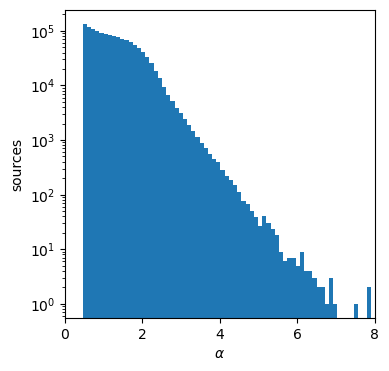

In [25]:
fig, ax = plt.subplots(figsize=(4,4))

_, _, _ = ax.hist(-alphatab['alpha_W1'], bins=100)
ax.set_xlim(0,8)
ax.set_yscale('log')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('sources')

$\Rightarrow$ matches the distribution in the S21 paper

### Step 4. HEALPix map and additional masking

#### `mk_hpx.py` $\rightarrow$ `catwise_agns_masked_final_alpha_hpx.fits`

`mk_hpx.py` turns the final catwise catalog (1,355,352 sources) into a HEALPix map with NSIDE=64 and also:

- sets neighbors of 0 pixel count (i.e. masked regions) to UNSEEN.
- makes dummy radii `primrad`, `secrad`, and `pa` for masking.

In [26]:
hpxmap = Table.read('/scratch/aew492/quasars/catalogs/catwise2020/catwise_agns_masked_final_alpha_hpx.fits', format='fits')

In [27]:
hpxmap

hpidx,ra,dec,l,b,elon,elat,density,alpha,primrad,secrad,pa
,deg,deg,deg,deg,deg,deg,,,deg,deg,deg
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,45.0,89.2690292915739,123.36647897577426,26.508638272058356,88.72720947914927,66.03858366802417,-1.6375e+30,--,0.0,0.0,0.0
1,135.0,89.2690292915739,123.62981029544957,27.515400643713654,91.27276797880909,66.0385839278291,-1.6375e+30,--,0.0,0.0,0.0
2,225.0,89.2690292915739,122.49253442153258,27.746514155377508,91.32684364717402,67.07209478570542,-1.6375e+30,--,0.0,0.0,0.0
3,315.0,89.2690292915739,122.23887680789957,26.73767840375658,88.67313247825355,67.07209451486413,-1.6375e+30,--,0.0,0.0,0.0
4,22.5,88.5380288373519,123.20357514412494,25.68666711860358,86.68220509872319,65.96541047456017,-1.6375e+30,--,0.0,0.0,0.0
5,67.5,88.5380288373519,124.26158565427497,26.275955435875268,88.66599138963245,65.20407791075338,-1.6375e+30,--,0.0,0.0,0.0
6,112.5,88.5380288373519,124.55488548267657,27.363749208745094,91.3339870688619,65.20407818305229,-1.6375e+30,--,0.0,0.0,0.0
7,157.5,88.5380288373519,123.89292047386692,28.31726535475212,93.31777248700976,65.96541115147706,-1.6375e+30,--,0.0,0.0,0.0


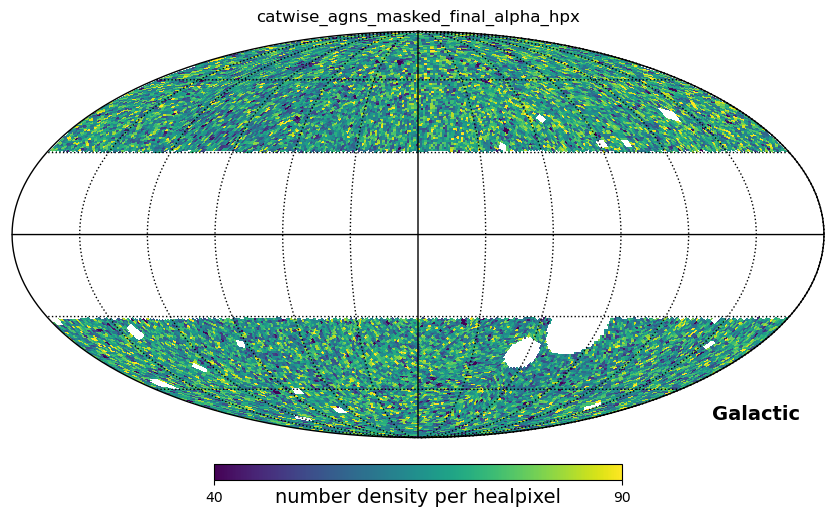

In [28]:
tools.mollview(hpxmap['density'], coord=['C','G'],min=40, max=90,
               title='catwise_agns_masked_final_alpha_hpx', badcolor='white')

#### Additional masking steps:
1. In the `MASKS_exclude_master_final.fits` list, add 1 degree to the primary radius (`radius`).
2. Make a secondary radius (`radius2`) as `(radius + 1) * ba` to avoid edge effects when excluding HEALPix pixels near the edge of masks.
3. Do an exclusionary sky ellipse match between the masks and the HEALPix map (I think this means the same as earlier, Sky Ellipses "All Match" Join 1 not 2, where 1 is the map and 2 is the mask file).
4. Make an additional cut of $|b|>31^\circ$ to deal with the edge effect near the galactic plane.

$\rightarrow$ This results in 22329 HEALPix.

In [29]:
# load masking file
mask = Table.read('/scratch/aew492/quasars/catalogs/catwise2020/MASKS_exclude_master_final.fits', format='fits')

In [30]:
mask

obj,ra,dec,radius,ba,pa
,,,deg,,deg
bytes16,float64,float64,float64,float32,float32
05595611+4556124,89.983801,45.936787,0.4344521992339051,1.0,0.0
05171768+5335102,79.323681,53.58617,0.3894986887897305,1.0,0.0
20065522-2713295,301.730112,-27.224884,0.5408564334782482,1.0,0.0
20023947-2742355,300.664474,-27.709867,0.4374113016847467,1.0,0.0
20275520-2815395,306.980011,-28.260984,0.5624708239741312,1.0,0.0
05052370+0110393,76.34878,1.177596,0.39082289731842773,1.0,0.0
19042415-0541055,286.100661,-5.684888,0.35005960628681804,1.0,0.0
15040422-2516549,226.017619,-25.281921,0.5205542541104391,1.0,0.0


In [31]:
# mask['radius'] += 1.
# mask['radius2'] = (mask['radius'] + 1) * mask['ba']
# mask.write('/scratch/aew492/quasars/catalogs/catwise2020/MASKS_exclude_master_final_mod4.fits', format='fits')

In [32]:
maskmod = Table.read('/scratch/aew492/quasars/catalogs/catwise2020/MASKS_exclude_master_final_mod4.fits', format='fits')

In [33]:
maskmod

obj,ra,dec,radius,ba,pa,radius2
,,,deg,,deg,deg
bytes16,float64,float64,float64,float32,float32,float64
05595611+4556124,89.983801,45.936787,1.4344521992339052,1.0,0.0,2.434452199233905
05171768+5335102,79.323681,53.58617,1.3894986887897305,1.0,0.0,2.3894986887897307
20065522-2713295,301.730112,-27.224884,1.5408564334782482,1.0,0.0,2.540856433478248
20023947-2742355,300.664474,-27.709867,1.4374113016847467,1.0,0.0,2.4374113016847465
20275520-2815395,306.980011,-28.260984,1.5624708239741312,1.0,0.0,2.562470823974131
05052370+0110393,76.34878,1.177596,1.3908228973184278,1.0,0.0,2.3908228973184276
19042415-0541055,286.100661,-5.684888,1.350059606286818,1.0,0.0,2.350059606286818
15040422-2516549,226.017619,-25.281921,1.520554254110439,1.0,0.0,2.520554254110439


Exclusionary sky ellipse match in TOPCAT $\rightarrow$ `hpx_final_masked.fits`

In [34]:
hpx_final = Table.read('/scratch/aew492/quasars/catalogs/catwise2020/hpx_final_masked.fits', format='fits')

In [35]:
hpx_final

hpidx,ra,dec,l,b,elon,elat,density,alpha,primrad,secrad,pa
,deg,deg,deg,deg,deg,deg,,,deg,deg,deg
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,45.0,89.2690292915739,123.36647897577426,26.508638272058356,88.72720947914927,66.03858366802417,-1.6375e+30,--,0.0,0.0,0.0
1,135.0,89.2690292915739,123.62981029544957,27.515400643713654,91.27276797880909,66.0385839278291,-1.6375e+30,--,0.0,0.0,0.0
2,225.0,89.2690292915739,122.49253442153258,27.746514155377508,91.32684364717402,67.07209478570542,-1.6375e+30,--,0.0,0.0,0.0
3,315.0,89.2690292915739,122.23887680789957,26.73767840375658,88.67313247825355,67.07209451486413,-1.6375e+30,--,0.0,0.0,0.0
4,22.5,88.5380288373519,123.20357514412494,25.68666711860358,86.68220509872319,65.96541047456017,-1.6375e+30,--,0.0,0.0,0.0
5,67.5,88.5380288373519,124.26158565427497,26.275955435875268,88.66599138963245,65.20407791075338,-1.6375e+30,--,0.0,0.0,0.0
6,112.5,88.5380288373519,124.55488548267657,27.363749208745094,91.3339870688619,65.20407818305229,-1.6375e+30,--,0.0,0.0,0.0
7,157.5,88.5380288373519,123.89292047386692,28.31726535475212,93.31777248700976,65.96541115147706,-1.6375e+30,--,0.0,0.0,0.0


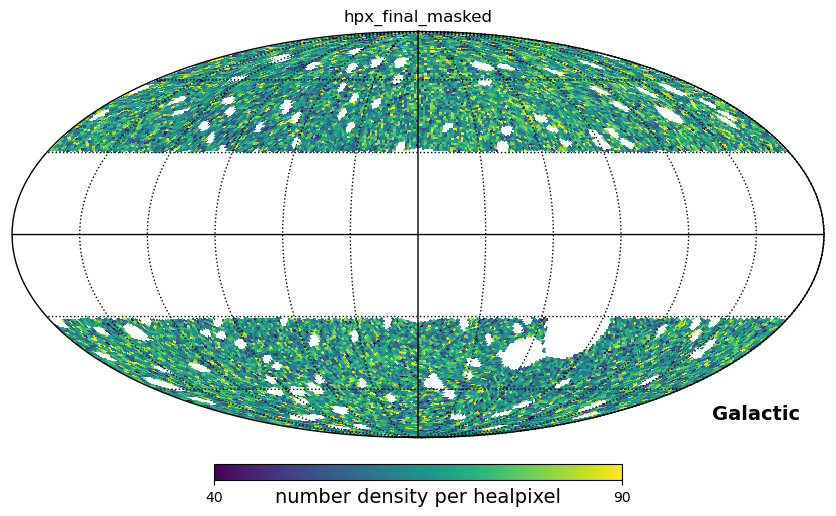

In [36]:
hpx_final_ = np.zeros(len(hpxmap))
hpx_final_[hpx_final['hpidx']] = hpx_final['density']
hpx_final_[hpx_final_==0.] = hp.UNSEEN
tools.mollview(hpx_final_, coord=['C','G'], min=40, max=90, title='hpx_final_masked', badcolor='white')

Extra galactic plane cut $|b|>31^\circ$:

In [37]:
hpx_final = hpx_final[np.abs(hpx_final['b']) > 31]
hpx_final  # 21618 vs. Secrest quotes 22329...

hpidx,ra,dec,l,b,elon,elat,density,alpha,primrad,secrad,pa
,deg,deg,deg,deg,deg,deg,,,deg,deg,deg
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
71,172.49999999999997,85.61313403601544,124.7153356176665,31.229726800190264,100.5860674548607,65.619304098904,52.425036518571005,-1.2981590909090908,0.0,0.0,0.0
72,187.50000000000003,85.61313403601544,123.41200448366939,31.495118601911656,101.07451473198431,66.74628467105045,84.59494529133049,-1.1889718309859154,0.0,0.0,0.0
73,202.5,85.61313403601544,122.0715702620171,31.450527734572855,100.81992542175065,67.8861689770251,66.72277375090856,-1.1743571428571429,0.0,0.0,0.0
74,217.5,85.61313403601544,120.79752858198957,31.099420223419816,99.73026797124335,68.95783853313554,69.10572995629815,-1.3778275862068972,0.0,0.0,0.0
96,160.71428571428572,84.88153790222776,126.12083354888998,31.425812981979252,101.25312022530063,64.43584804086758,65.53129564821376,-1.3096909090909095,0.0,0.0,0.0
97,173.57142857142858,84.88153790222776,124.92214628200401,31.945290742247145,102.33675137056156,65.48465707909372,48.85060221048662,-1.2720487804878047,0.0,0.0,0.0
98,186.42857142857142,84.88153790222776,123.60863284338168,32.21287439965959,102.90188133579016,66.60610379707708,64.33981754551897,-1.2174074074074075,0.0,0.0,0.0
99,199.28571428571428,84.88153790222776,122.25570668206038,32.2129234700419,102.84993897653374,67.75059357761843,67.91425185360335,-1.2291052631578945,0.0,0.0,0.0


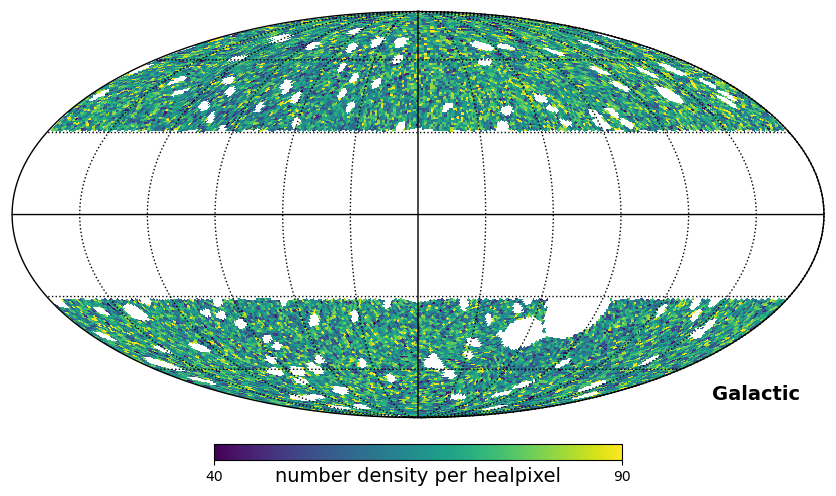

In [40]:
hpx_final_ = np.zeros(len(hpxmap))
hpx_final_[hpx_final['hpidx']] = hpx_final['density']
hpx_final_[hpx_final_==0.] = hp.UNSEEN
tools.mollview(hpx_final_, coord=['C','G'], min=40, max=90, badcolor='white')

Text(0, 0.5, 'sources')

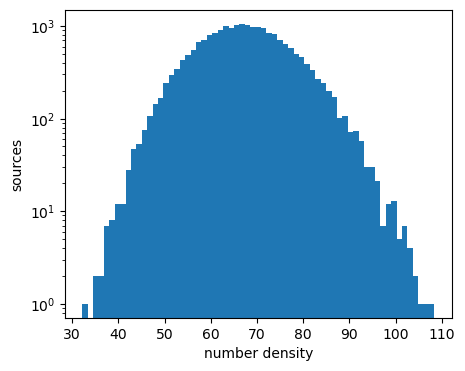

In [41]:
fig, ax = plt.subplots(figsize=(5,4))

n, bins, _, = ax.hist(hpx_final['density'], bins=65)
ax.set_yscale('log')
ax.set_xlabel('number density')
ax.set_ylabel('sources')

In [42]:
bins[np.argmax(n)]  # peak at 66 vs Secrest quotes peak at 67

66.1911912127832

In [43]:
# hpx_final.write('/scratch/aew492/quasars/catalogs/catwise2020/hpx_final_masked_bcut.fits', format='fits')

**measure dipole** in this sample

In [44]:
# make map again
hpxmap_final = np.full(len(catmap), hp.UNSEEN)
hpxmap_final[hpx_final['hpidx']] = hpx_final['density']

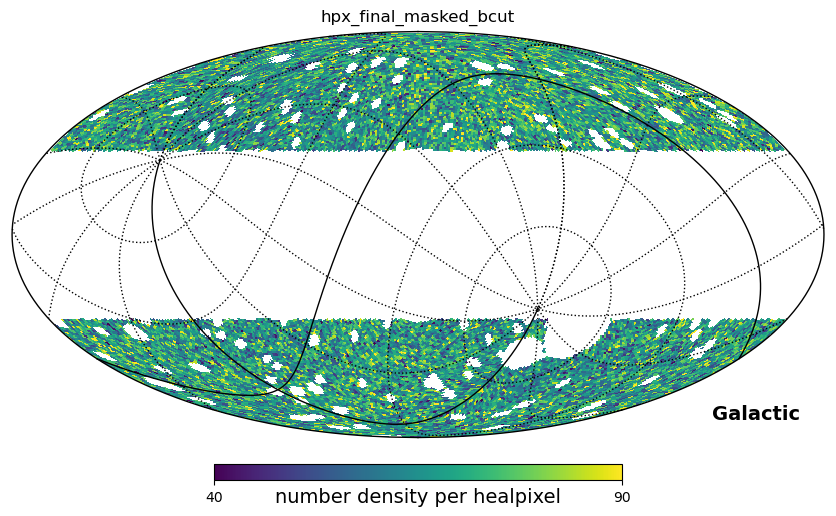

In [45]:
tools.mollview(hpxmap_final, coord=['C','G'], graticule_coord=['C'], min=40, max=90,
              title='hpx_final_masked_bcut', badcolor='white')

In [46]:
amps, err = dipole.fit_dipole(hpxmap_final, idx=(hpxmap_final!=hp.UNSEEN))

In [47]:
amp, dir_ = dipole.get_dipole(amps, frame='icrs')
amp, dir_.galactic

(0.016779751797300672,
 <SkyCoord (Galactic): (l, b) in deg
     (249.59525149, 22.96477124)>)

### Step 5. correct for ecliptic latitude trend with `hpx_vs_direction.py` $\rightarrow$ `steradian_smoothed.fits`

In [48]:
ster_smoothed = Table.read('/scratch/aew492/quasars/catalogs/catwise2020/steradian_smoothed.fits', format='fits')

In [49]:
ster_smoothed

hpidx,ra,dec,l,b,elon,elat,density,alpha,primrad,secrad,pa,denscorr,smoothed,sterr,Nsmooth,alphasmoothed,alphasterr,smoothed_uncorrected,sterr_uncorrected
,deg,deg,deg,deg,deg,deg,,,deg,deg,deg,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
71,172.49999999999997,85.61313403601544,124.7153356176665,31.229726800190264,100.5860674548607,65.619304098904,52.425036518571005,-1.2981590909090908,0.0,0.0,0.0,55.78906048985826,69.3176189550108,0.23292559825473835,1730.0,-1.2731631099086227,0.001973449501168554,66.2275871868406,0.23452078435723345
72,187.50000000000003,85.61313403601544,123.41200448366939,31.495118601911656,101.07451473198431,66.74628467105045,84.59494529133049,-1.1889718309859154,0.0,0.0,0.0,88.01674478632889,69.25089579234628,0.23139179268876947,1747.0,-1.2734733049013247,0.0019775634670910545,66.13487785822228,0.23298081628124873
73,202.5,85.61313403601544,122.0715702620171,31.450527734572855,100.81992542175065,67.8861689770251,66.72277375090856,-1.1743571428571429,0.0,0.0,0.0,70.20301028943325,69.27859763454467,0.23256822099619265,1738.0,-1.2741281975308387,0.001976128280922994,66.13183351815658,0.2340729374514135
74,217.5,85.61313403601544,120.79752858198957,31.099420223419816,99.73026797124335,68.95783853313554,69.10572995629815,-1.3778275862068972,0.0,0.0,0.0,72.64090645685933,69.26910711982875,0.23527772723835008,1710.0,-1.2741127368893765,0.0019937546051965746,66.08871230444524,0.23672703609022624
96,160.71428571428572,84.88153790222776,126.12083354888998,31.425812981979252,101.25312022530063,64.43584804086758,65.53129564821376,-1.3096909090909095,0.0,0.0,0.0,68.83464883667467,69.25817790995899,0.23392466274596596,1745.0,-1.273003430750235,0.0019476302913501726,66.20999434969148,0.23528803073534274
97,173.57142857142858,84.88153790222776,124.92214628200401,31.945290742247145,102.33675137056156,65.48465707909372,48.85060221048662,-1.2720487804878047,0.0,0.0,0.0,52.207723398994865,69.2388319091628,0.23045245481749296,1783.0,-1.2735108801790287,0.001942621162380685,66.16545869894699,0.23186933359544876
98,186.42857142857142,84.88153790222776,123.60863284338168,32.21287439965959,102.90188133579016,66.60610379707708,64.33981754551897,-1.2174074074074075,0.0,0.0,0.0,67.75443056045883,69.26022822229297,0.2290351224095902,1799.0,-1.273221691118208,0.0019390543840554285,66.16048086086526,0.23051822578371875
99,199.28571428571428,84.88153790222776,122.25570668206038,32.2129234700419,102.84993897653374,67.75059357761843,67.91425185360335,-1.2291052631578945,0.0,0.0,0.0,71.38753801525672,69.24916679617402,0.2298875484861058,1791.0,-1.273782863217539,0.0019439614663200125,66.12004948455373,0.23133519543528402


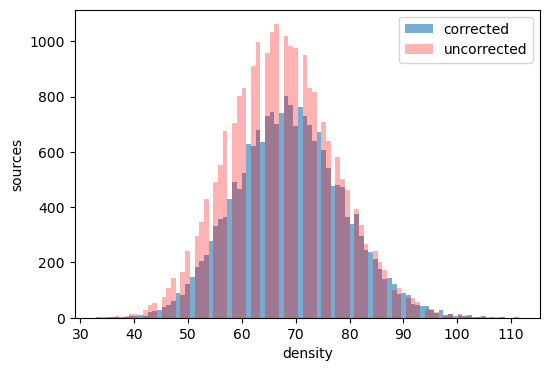

In [50]:
fig, ax = plt.subplots(figsize=(6,4))
n, bins, _ = ax.hist(ster_smoothed['denscorr'], bins=90, alpha=0.6, label='corrected')
_, _, _ = ax.hist(ster_smoothed['density'], bins=bins, alpha=0.3, color='r', label='uncorrected')
ax.set_xlabel('density')
ax.set_ylabel('sources')
ax.legend()

Text(0, 0.5, 'sources')

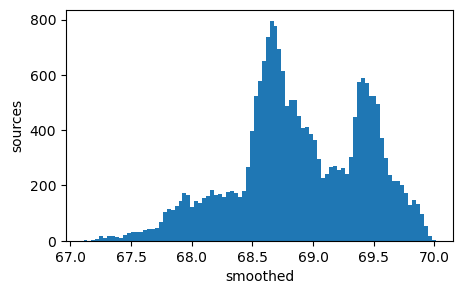

In [51]:
fig, ax = plt.subplots(figsize=(5,3))
n, bins, _ = ax.hist(ster_smoothed['smoothed'], bins=89)
ax.set_xlabel('smoothed')
ax.set_ylabel('sources')

In [52]:
smoothmap = np.zeros_like(hpxmap_final)
smoothmap[ster_smoothed['hpidx']] = ster_smoothed['smoothed']
smoothmap[smoothmap==0.] = np.nan

In [53]:
np.nanmean(smoothmap)

68.88915213031115

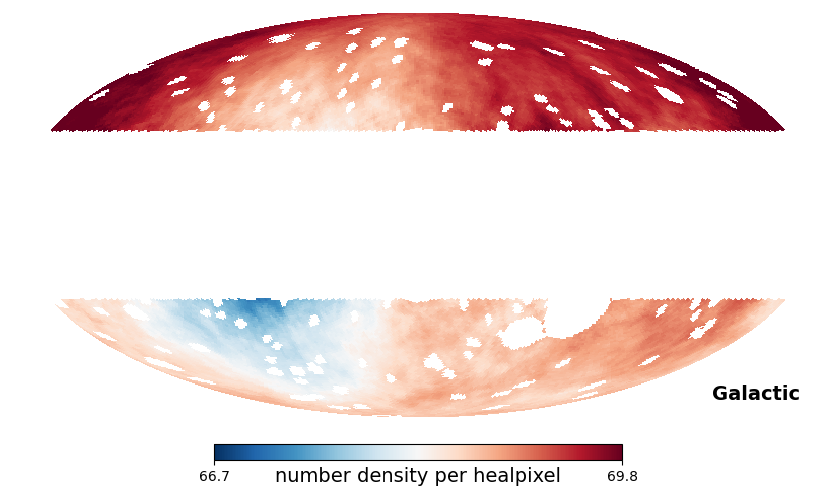

In [54]:
tools.mollview(smoothmap, coord=['C','G'], min=66.7, max=69.8, cmap='RdBu_r', graticule=False, badcolor='white')

#### density-corrected map

In [55]:
finalmap = np.zeros_like(smoothmap)
finalmap[ster_smoothed['hpidx']] = ster_smoothed['denscorr']
finalmap[finalmap==0.] = np.nan

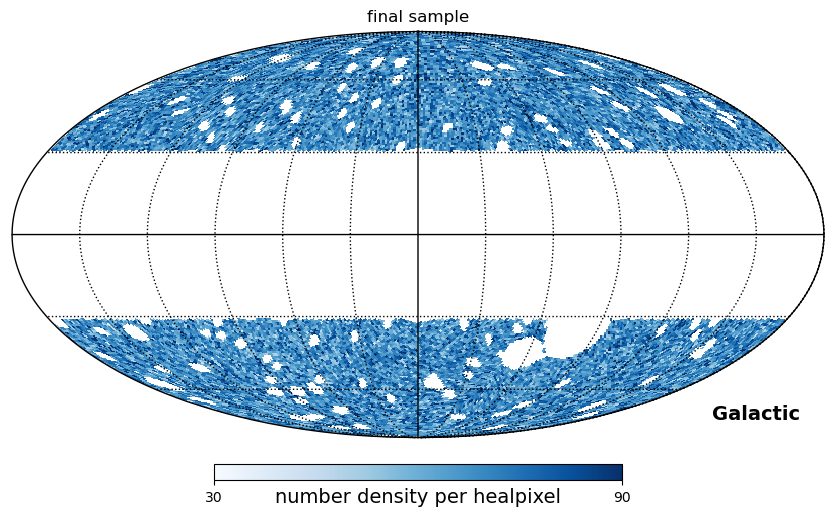

In [56]:
tools.mollview(finalmap, coord=['C','G'], title='final sample', min=30, max=90, badcolor='white', cmap='Blues')

### **measure dipole** in this final catalog

#### with densities with ecliptic latitude correction

In [59]:
# Secrest's function
dvec, d = dipole.getDipoleVectors_healpy(finalmap, mask=(finalmap!=hp.UNSEEN))
print('We find the dipole amplitude D={:0.5f} in direction (lon,lat)=({:0.2f},{:0.2f})deg'.format(d,*hp.vec2dir(dvec, lonlat=True)))

We find the dipole amplitude D=0.01470 in direction (lon,lat)=(140.77,-7.38)deg


In [61]:
# my function
amps, err = dipole.fit_dipole(finalmap, idx=(~np.isnan(finalmap)))
amp, dir_ = dipole.get_dipole(amps, frame='icrs')
amp, dir_

(0.014698099418849371,
 <SkyCoord (ICRS): (ra, dec) in deg
     (140.77303607, -7.38068054)>)

In [62]:
dir_.galactic

<SkyCoord (Galactic): (l, b) in deg
    (239.55527936, 28.93161242)>

$\rightarrow$ Same result as Secrest's functions.

**S21 finds $\mathcal{D}=0.01554$ towards $(l,b)=(238.2^\circ,28.8^\circ)$**

#### with uncorrected densities

In [63]:
finalmap_uncorr = np.zeros_like(smoothmap)
finalmap_uncorr[ster_smoothed['hpidx']] = ster_smoothed['density']
finalmap_uncorr[finalmap_uncorr==0.] = np.nan
amps, err = dipole.fit_dipole(finalmap_uncorr, idx=(~np.isnan(finalmap_uncorr)))
amp, dir_ = dipole.get_dipole(amps, frame='icrs')
amp, dir_.galactic

(0.016779751797300672,
 <SkyCoord (Galactic): (l, b) in deg
     (249.59525149, 22.96477124)>)